<hr style="height:2px;">

# Demo: Phase Retrieval

In this tutorial we will use Pycro-Manager to easily collect a quantitative phase image of a sample! We will be using the [Transport of Intensity Equation (TIE)](https://en.wikipedia.org/wiki/Transport-of-intensity_equation)  to retrieve quantitative phase from a z-stack aquired by pycromanager on your microscope.

Please install [Pycro-Manager](https://pycro-manager.readthedocs.io/en/latest/setup.html) locally before running this Colab notebook.

<hr style="height:2px;">

## Part 1: Setup

If you have not yet, install Pycro-Manager:   
```
pip install pycromanager
```
Make sure you have NumPy, SciPy, TensorFlow (version >=2.3), and TensorFlow Probability installed before preceding.
Run the following block (it's quite long! Don't worry!):

In [52]:
import numpy as np
from numpy import fft
import tensorflow as tf   # requires TensorFlow version >= 2.3
from tensorflow import signal
from tensorflow import image
import matplotlib.pyplot as plt
import tensorflow_probability as tfp   # pip install --upgrade tensorflow-probability
from scipy.io import loadmat
import time
from pycromanager import Bridge

class GP_TIE(tf.Module):

    def __init__(self):
        self.SigmafStack, self.SigmanStack, self.SigmalStack = None, None, None
        self.dIdzStack, self.CoeffStack, self.Coeff2Stack = None, None, None

    @tf.function
    def __call__(self, Ividmeas, z_vec, lambd, ps, zfocus, Nsl, eps1, eps2, reflect):

        RePhase1 = self.RunGaussianProcess(Ividmeas, zfocus, z_vec, lambd, ps, Nsl, eps1, eps2, reflect)
        RePhase1 = RePhase1 / tf.cast(tf.reduce_mean(Ividmeas), tf.float32)
        return RePhase1

    @tf.function
    def RunGaussianProcess(self, Ividmeas,zfocus,z_vec,lambd,ps,Nsl,eps1,eps2,reflect):
        Ividmeas = tf.cast(Ividmeas, tf.float32)
        z_vec = tf.cast(z_vec, tf.float32)
        lambd = tf.cast(lambd, tf.float32)
        ps = tf.cast(ps, tf.float32)

        (Nx, Ny, Nz) = Ividmeas.shape
        I0 = Ividmeas[:,:,zfocus]
        zfocus = z_vec[zfocus]

        ### Calculate S_c ###

        freqs = self.CalFrequency(Ividmeas[:,:,0], lambd, ps, 1)
        max_freq = tf.reduce_max(freqs)
        max_freq = tf.sqrt(max_freq / (lambd / 2))
        freq_cutoff = tf.linspace(0.0,1.0,Nsl) * tf.cast(max_freq, tf.float32)
        freq_cutoff = freq_cutoff ** 2 * lambd / 2

        if self.SigmalStack is None:
            self.SigmalStack = tf.Variable(tf.zeros((Nsl,1)))

        freq_to_sc = tf.linspace(1.2,1.1,Nsl)
        p = Nz / (tf.reduce_max(z_vec) - tf.reduce_min(z_vec))

        # Figure out GP regression
        self.SigmafStack = tf.ones(Nsl) * 10.0**-7 # should be 10.0**-9
        self.SigmanStack = tf.ones(Nsl)

        for k in range(Nsl):
            f1 = freq_cutoff[k]
            sc = f1 * freq_to_sc[k]
            a = tf.cast(sc**2 * 2 * np.pi**2, tf.float32)
            b = tf.cast(tf.math.log((p * (2*np.pi)**0.5)/self.SigmanStack[k]), tf.float32)
            def fu2(x):
                return a*tf.cast(tf.exp(x), tf.float32) -tf.cast(0.5*x-b, tf.float32)
            x = tfp.math.secant_root(fu2, [5.0], max_iterations=10)[0] # try implementing
            Sigmal = tf.exp(x)
            self.SigmalStack[k].assign(Sigmal)

        if self.dIdzStack is None:
            self.dIdzStack = tf.Variable(tf.zeros((Nx,Ny,Nsl)))
        if self.CoeffStack is None:
            self.CoeffStack = tf.Variable(tf.zeros((Nz,Nsl)))
        if self.Coeff2Stack is None:
            self.Coeff2Stack = tf.Variable(tf.zeros((Nz,Nsl)))

        for j in range(Nsl):
            # print(j)
            Sigmal = self.SigmalStack[j]
            Sigman = self.SigmanStack[j]
            Sigmaf = self.SigmafStack[j]

            ### GP Regression step
            dIdz, Coeff, Coeff2 = self.GPRegression(Ividmeas, zfocus, z_vec, Sigmaf, Sigmal, Sigman)
            self.dIdzStack[:,:,j].assign(2*np.pi/lambd*ps**2*dIdz)
            self.CoeffStack[:,j].assign(Coeff)
            self.Coeff2Stack[:,j].assign(Coeff2[0])

        dIdzC = self.CombinePhase(self.dIdzStack, freq_cutoff, freqs, self.CoeffStack, self.Coeff2Stack)

        ### poisson solver

        Del2_Psi_xy = (-2*np.pi/lambd) * dIdzC

        N = dIdzC.shape[0]
        Psi_xy = self.poisson_solve(Del2_Psi_xy, ps, eps1, 0, reflect)
        xs = tf.range(0,len(Psi_xy),1)

        # return tf.math.real(Psi_xy) 53.0

        Grad_Psi_x, Grad_Psi_y = self.gradient_2d(Psi_xy/tf.cast(ps, tf.complex64))
        Grad_Psi_x = Grad_Psi_x / tf.cast(I0 + eps2, tf.complex64)
        Grad_Psi_y = Grad_Psi_y / tf.cast(I0 + eps2, tf.complex64)

        grad2x, _ = self.gradient_2d(Grad_Psi_x/tf.cast(ps, tf.complex64))
        _, grad2y = self.gradient_2d(Grad_Psi_y/tf.cast(ps, tf.complex64))

        Del2_Psi_xy = grad2x + grad2y

        # return tf.math.real(Del2_Psi_xy) 48.0

        Phi_xy = self.poisson_solve(Del2_Psi_xy, ps, eps1, 1, reflect)

        dcval = (tf.reduce_sum(Phi_xy[:,0]) + tf.reduce_sum(Phi_xy[0,:]) + tf.reduce_sum(Phi_xy[N-1,:]) + tf.reduce_sum(Phi_xy[:,N-1]))/(4*N)

        RePhase = -1 * (Phi_xy - dcval)
        return tf.math.real(RePhase) # 49.0

    @tf.function
    def gradient_2d(self, xy):
        grad_x = tf.concat([xy[:,1:], tf.expand_dims(xy[:,-1], 1)], 1) - xy
        grad_y = tf.concat([xy[1:], tf.expand_dims(xy[-1], 0)], 0) - xy

        return grad_x, grad_y

    @tf.function
    def CalFrequency(self, img, lambd, ps, dz):
        (nx, ny) = img.shape

        dfx = 1/nx/ps
        dfy = 1/ny/ps

        (Kxdown, Kydown) = np.mgrid[-nx//2:nx//2,-ny//2:ny//2]

        Kxdown = Kxdown * dfx
        Kydown = Kydown * dfy

        freqs = lambd * np.pi * (Kxdown ** 2 + Kydown ** 2)

        # normalized for sampling step and GP Regression ?
        freqs = freqs * dz / (2 * np.pi)

        return freqs

    @tf.function
    def CombinePhase(self, dIdzStack, Frq_cutoff, freqs, CoeffStack, Coeff2Stack):
        def F(x):
            return signal.ifftshift(signal.fft2d(signal.fftshift(x)))

        def Ft(x):
            return signal.ifftshift(signal.ifft2d(signal.fftshift(x)))

        Nx, Ny, Nsl = dIdzStack.shape

        dIdzC_fft = tf.zeros((Nx,Ny), dtype=tf.complex64)
        Maskf = tf.zeros((Nx,Ny))

        f0 = 0
        f1 = 1
        
        for k in range(Nsl):
            dIdz_fft = F(tf.cast(dIdzStack[:,:,k], tf.complex64))

            f1 = Frq_cutoff[k]
            Mask0 = tf.zeros((Nx,Ny), dtype=tf.complex64)
            Mask1 = tf.ones((Nx,Ny), dtype=tf.complex64)
            Maskf = tf.where((freqs<=f1) & (freqs>f0), Mask1, Mask0)
            f0 = f1
            dIdzC_fft = dIdzC_fft + (dIdz_fft * Maskf)

        return tf.math.real(Ft(dIdzC_fft))

    @tf.function
    def poisson_solve(self, func, ps, eps, symm, reflect):
        N = len(func)

        if reflect != 0:
            N = N * 2
            func = tf.concat([func, tf.image.flip_left_right(func)], axis=1)
            func = tf.concat([func, tf.image.flip_up_down(func)], axis=0)

        wx = 2 * np.pi * tf.range(0,N,1, dtype=tf.float32)/N
        fx = 1/(2 * np.pi * ps) * (wx - np.pi * (1 - N % 2 / N))
        [Fx, Fy] = tf.meshgrid(fx, fx)
        func_ft = signal.fftshift(signal.fft2d(tf.cast(func, tf.complex64)))

        Psi_ft = func_ft / tf.cast((-4 * np.pi**2 * (Fx**2 + Fy**2 + eps)), tf.complex64)
        if (symm):
            Psi_xy = signal.ifft2d(signal.ifftshift(Psi_ft))
        else:
            Psi_xy = signal.ifft2d(signal.ifftshift(Psi_ft))

        if reflect != 0:
            N = N//2
            Psi_xy = Psi_xy[:N,:N]
        return Psi_xy

    @tf.function
    def mrdivide(self, A, B):
        # Solves A / B or xA = B
        return tf.matmul(A, tf.linalg.inv(B))

    @tf.function
    def GPRegression(self, Ividmeas, zfocus, z, Sigmaf, Sigmal, Sigman):
        Nx, Ny, Nz = Ividmeas.shape
        ones = tf.ones((Nz,1), dtype=tf.float32)
        KZ = tf.matmul(ones, tf.transpose(z)) - tf.matmul(z, tf.transpose(ones))

        K = Sigmaf * (tf.exp(-1/2/Sigmal*(KZ**2)))
        K = K + (Sigman * tf.eye(Nz))
        L = tf.transpose(tf.linalg.cholesky(K))
        z2 = zfocus

        Nz2 = len(z2)
        ones2 = tf.ones((Nz2,1))
        KZ2 = ones * tf.transpose(z2) - z * tf.transpose(ones2)


        D = Sigmaf * (tf.exp((-1/2/Sigmal)*(KZ2**2))) / -Sigmal * KZ2
        Coeff = self.mrdivide(self.mrdivide(tf.transpose(D), L), tf.transpose(L))[0] #D.T/L/L.T
        D2 = Sigmaf * (tf.exp((-1/2/Sigmal)*(KZ2**2)))
        Coeff2 = self.mrdivide(self.mrdivide(tf.transpose(D2), L), tf.transpose(L)) #D2.T/L/L.T

        dIdz = tf.zeros((Nx,Ny))

        for k in range(Nz):
            dIdz = dIdz + tf.cast(Ividmeas[:,:,k], tf.float32) * Coeff[k]

        return dIdz, Coeff, Coeff2

<hr style="height:2px;">

## Part 2: Collect a Z-Stack of your sample

First verify you have a working installation of [Pycro-Manager](https://pycro-manager.readthedocs.io/en/latest/setup.html). Open Micro-Manager, select tools-options, and check the box that says Run server on port 4827 (you only need to do this once). Run:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from pycromanager import Bridge, Acquisition, multi_d_acquisition_events
bridge = Bridge()
core = bridge.get_core()

The output should look something like:   
```
Out[1]: JavaObjectShadow for : mmcorej.CMMCore
```
We will be using [aquisition events](https://pycro-manager.readthedocs.io/en/latest/acq_intro.html), an extremely useful feature of Pycro-Manager that allows you to create sets of hardware postitions and images to collect images.
Let's create an aquisition event that will collect a z-stack of the sample we have staged on our microscope right now. The following code will create the aquisition event and initiate collection of the z-stack. Make sure your microscope is ready, and specify the filepath you want to store the images in.

In [ ]:
Ividmeas = []
z_vec = []
if __name__ == '__main__': #this is important, don't forget it
        with Acquisition(directory='/path/to/saving/dir', name='tie_acq') as acq:
            # Generate the events for a single z-stack
            events = multi_d_acquisition_events(z_start=0, z_end=5, z_step=1)
            dataset = acq.get_dataset()
            acq.acquire(events)
            Ividmeas = dataset.as_array()
            z_vec = events['z']

Our images are now in data! Let's apply TIE and see the results:

In [ ]:
if z_vec.shape[0] == 1:
    z_vec = z_vec.T

In [53]:
test_path = '/home/ryan/Desktop/Imaging/moustache_man_stack.mat'

data = loadmat(test_path)

In [54]:
Ividmeas = data['Istack']   # 512x512x3 array

In [56]:
z_vec = data['zvec']
if z_vec.shape[0] == 1:
    z_vec = z_vec.T
print(z_vec)

[[-2.e-05]
 [ 0.e+00]
 [ 2.e-05]]


In [57]:
print(data['lambda'])

[[6.328e-07]]


In [32]:
lambd = data['lambda'][0][0]
ps = data['ps']
zfocus = 1
Nsl = 50
eps1 = 1
eps2 = 1
reflect = False

phase:  (512, 512)
time:  19.425032377243042


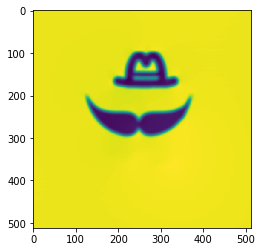

In [43]:
gptie = GP_TIE()
# print("loading data")
start = time.time()
phase = gptie(Ividmeas, z_vec, lambd, ps, zfocus, Nsl, eps1, eps2, reflect).numpy()
end = time.time()
print("phase: ", phase.shape)
print("time: ", end - start)
plt.imshow(phase)
plt.show()

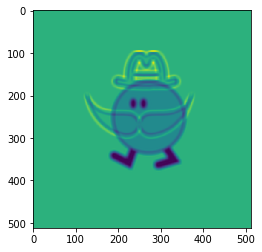

In [47]:
mou = Ividmeas[:,:,0]
plt.imshow(mou)
plt.show()

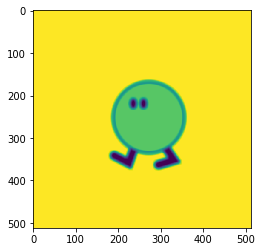

In [48]:
mou = Ividmeas[:,:,1]
plt.imshow(mou)
plt.show()

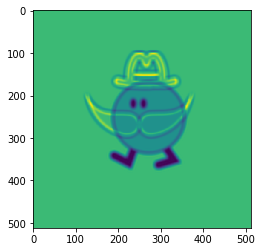

In [51]:
mou = Ividmeas[:,:,2]
plt.imshow(mou)
plt.show()